In [5]:
import pandas as pd
import numpy as np
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, roc_auc_score, 
    average_precision_score, f1_score, classification_report
)
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder

# Load data
plays = pd.read_csv('plays.csv')
players = pd.read_csv('players.csv')
player_play = pd.read_csv('player_play.csv')
games = pd.read_csv('games.csv')

# Define team list
teams = ['KC']

# Initialize storage
xgb_best_params = {}
rf_best_params = {}
test_metrics_results = {}
classification_reports = {}


In [6]:

# Loop through each team
for team in teams:
    print(f"Processing team: {team}")
    
    # Filter data for the current team
    team_plays = plays[plays['possessionTeam'] == team]
    team_player_play = player_play[player_play['teamAbbr'] == team]
    team_games = games[(games['homeTeamAbbr'] == team) | (games['visitorTeamAbbr'] == team)]
    
    # Create a copy to avoid SettingWithCopyWarning
    team_plays = team_plays.copy()
    
    # Feature engineering
    team_plays['scoreDifferential'] = team_plays['preSnapHomeScore'] - team_plays['preSnapVisitorScore']
    team_plays['isLeading'] = (team_plays['scoreDifferential'] > 0).astype(int)
    team_plays['isRedZone'] = (team_plays['absoluteYardlineNumber'] <= 20).astype(int)
    team_plays['shortYardage'] = (team_plays['yardsToGo'] <= 2).astype(int)
    team_plays['thirdAndLong'] = ((team_plays['down'] == 3) & (team_plays['yardsToGo'] > 7)).astype(int)
    team_plays['fourthQuarter'] = (team_plays['quarter'] == 4).astype(int)
    team_plays['twoMinuteDrill'] = (team_plays['quarter'] >= 2) & (
        team_plays['gameClock'].str.split(':').str[0].astype(int) <= 2)
    team_plays['playType'] = team_plays['passResult'].apply(lambda x: 0 if pd.isnull(x) else 1)
    #IT IS 1 if its a pass else its a 0  (0 means run, 1 mean Pass)
    
    # Prepare data for modeling
    features = [
        'yardsToGo', 'quarter', 'down', 'expectedPoints', 'scoreDifferential', 'isLeading', 
        'isRedZone', 'shortYardage', 'thirdAndLong', 'fourthQuarter', 'twoMinuteDrill', 
        'preSnapHomeScore', 'preSnapVisitorScore', 'offenseFormation'
    ]
    
    data = team_plays[features + ['playType']]
    
    # One-hot encode offensive formations
    encoder = OneHotEncoder(sparse_output=False)
    encoded_formations = encoder.fit_transform(data[['offenseFormation']])
    formation_columns = [f'formation_{cat}' for cat in encoder.categories_[0]]
    encoded_df = pd.DataFrame(encoded_formations, columns=formation_columns)
    
    # Merge encoded features back into the dataset
    data = pd.concat([data.reset_index(drop=True), encoded_df], axis=1).drop(columns=['offenseFormation'])
    
    X = data.drop(columns=['playType'])
    y = data['playType']
    
    # Split the data
    X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=28, stratify=y)
    X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=28, stratify=y_train_full)
    
    # XGBoost Hyperparameter Tuning
    def xgb_objective(trial):
        params = {
            'objective': 'binary:logistic',
            'eval_metric': 'auc',
            'max_depth': trial.suggest_int('max_depth', 3, 5),
            'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.15),
            'subsample': trial.suggest_float('subsample', 0.5, 0.8),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.75, 0.95),
            'n_estimators': trial.suggest_int('n_estimators', 300, 800),
            'reg_alpha': trial.suggest_float('reg_alpha', 2, 5.5),
            'reg_lambda': trial.suggest_float('reg_lambda', 2, 5),
        }
        
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        auc_scores = []
        
        for train_idx, val_idx in skf.split(X_train, y_train):
            X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
            y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
            
            model = xgb.XGBClassifier(**params)
            model.fit(X_train_fold, y_train_fold, eval_set=[(X_val_fold, y_val_fold)], verbose=False)
            
            y_pred = model.predict_proba(X_val_fold)[:, 1]
            auc_scores.append(roc_auc_score(y_val_fold, y_pred))
        
        return np.mean(auc_scores)
    
    xgb_study = optuna.create_study(direction='maximize')
    xgb_study.optimize(xgb_objective, n_trials=200)
    xgb_best_params[team] = xgb_study.best_params
    
    # Random Forest Hyperparameter Tuning
    def rf_objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 200, 400),
            'max_depth': trial.suggest_int('max_depth', 3, 4),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 6),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 3),
            'max_features': trial.suggest_float('max_features', 0.35, 0.55)
        }
        
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=28)
        f1_scores = []
        
        for train_idx, val_idx in skf.split(X_train, y_train):
            X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
            y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
            
            model = RandomForestClassifier(**params, random_state=28, n_jobs=-1, class_weight='balanced')
            model.fit(X_train_fold, y_train_fold)
            
            y_pred = model.predict(X_val_fold)
            f1_scores.append(f1_score(y_val_fold, y_pred))
        
        return np.mean(f1_scores)
    
    rf_study = optuna.create_study(direction='maximize')
    rf_study.optimize(rf_objective, n_trials=200)
    rf_best_params[team] = rf_study.best_params
    
    # Train final Random Forest model
    rf_model = RandomForestClassifier(**rf_study.best_params, random_state=28, n_jobs=-1, class_weight='balanced')
    rf_model.fit(X_train_full, y_train_full)
    
    # Evaluate on the test set
    y_test_pred = rf_model.predict(X_test)
    y_test_pred_proba = rf_model.predict_proba(X_test)[:, 1]
    
    test_metrics = {
        'accuracy': accuracy_score(y_test, y_test_pred),
        'precision': precision_score(y_test, y_test_pred),
        'recall': recall_score(y_test, y_test_pred),
        'f1_score': f1_score(y_test, y_test_pred),
        'roc_auc': roc_auc_score(y_test, y_test_pred_proba),
        'pr_auc': average_precision_score(y_test, y_test_pred_proba)
    }
    test_metrics_results[team] = test_metrics
    classification_reports[team] = classification_report(y_test, y_test_pred)
    
    # Print the results for the current team
    print(f"Team: {team}")
    print(f"XGBoost Best Parameters: {xgb_best_params[team]}")
    print(f"Random Forest Best Parameters: {rf_best_params[team]}")
    print("Test Metrics:")
    for metric, value in test_metrics.items():
        print(f"  {metric}: {value:.4f}")


[I 2024-12-03 21:01:03,650] A new study created in memory with name: no-name-665069d0-a471-408d-afd4-8c56c8f9fb58


Processing team: KC


[I 2024-12-03 21:01:05,301] Trial 0 finished with value: 0.7804347826086956 and parameters: {'max_depth': 4, 'learning_rate': 0.09964093161757241, 'subsample': 0.6892196041757017, 'colsample_bytree': 0.9317679141098638, 'n_estimators': 738, 'reg_alpha': 4.639135664308988, 'reg_lambda': 4.934839329859887}. Best is trial 0 with value: 0.7804347826086956.
[I 2024-12-03 21:01:06,776] Trial 1 finished with value: 0.7464997136690014 and parameters: {'max_depth': 3, 'learning_rate': 0.09919502302178115, 'subsample': 0.5504291252942292, 'colsample_bytree': 0.769143496792141, 'n_estimators': 613, 'reg_alpha': 2.381221872288305, 'reg_lambda': 2.0161579210652514}. Best is trial 0 with value: 0.7804347826086956.
[I 2024-12-03 21:01:08,392] Trial 2 finished with value: 0.7740231707854279 and parameters: {'max_depth': 3, 'learning_rate': 0.11408665867810559, 'subsample': 0.7857470429314184, 'colsample_bytree': 0.8969812713042763, 'n_estimators': 757, 'reg_alpha': 3.683397523904522, 'reg_lambda': 3.8

Team: KC
XGBoost Best Parameters: {'max_depth': 3, 'learning_rate': 0.0538541025885735, 'subsample': 0.6853761664792607, 'colsample_bytree': 0.9413928236975928, 'n_estimators': 492, 'reg_alpha': 5.175471769305277, 'reg_lambda': 3.5224681139068257}
Random Forest Best Parameters: {'n_estimators': 281, 'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 0.42508346812834447}
Test Metrics:
  accuracy: 0.8396
  precision: 0.8434
  recall: 0.9459
  f1_score: 0.8917
  roc_auc: 0.8484
  pr_auc: 0.9240


#### FINAL PARAMETERS
Team: KC
XGBoost Best Parameters: {'max_depth': 3, 'learning_rate': 0.0538541025885735, 'subsample': 0.6853761664792607, 'colsample_bytree': 0.9413928236975928, 'n_estimators': 492, 'reg_alpha': 5.175471769305277, 'reg_lambda': 3.5224681139068257}
Random Forest Best Parameters: {'n_estimators': 281, 'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 0.42508346812834447}
Test Metrics:
  accuracy: 0.8396
  precision: 0.8434
  recall: 0.9459
  f1_score: 0.8917
  roc_auc: 0.8484
  pr_auc: 0.9240


XGBoost Metrics:
  accuracy: 0.8113
  precision: 0.8000
  recall: 0.9730
  f1_score: 0.8780
  roc_auc: 0.8573
  pr_auc: 0.9266

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.44      0.58        32
           1       0.80      0.97      0.88        74

    accuracy                           0.81       106
   macro avg       0.84      0.71      0.73       106
weighted avg       0.82      0.81      0.79       106



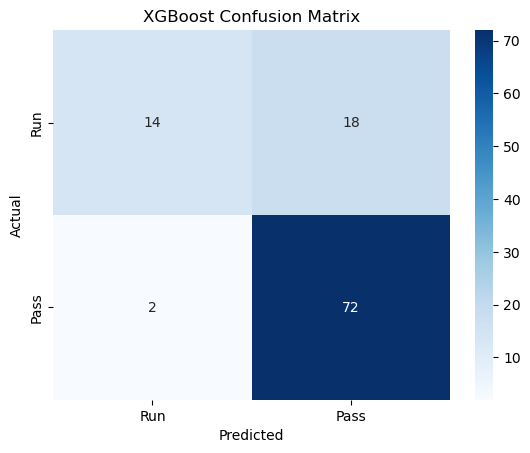


Random Forest Metrics:
  accuracy: 0.8396
  precision: 0.8434
  recall: 0.9459
  f1_score: 0.8917
  roc_auc: 0.8484
  pr_auc: 0.9240

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.59      0.69        32
           1       0.84      0.95      0.89        74

    accuracy                           0.84       106
   macro avg       0.83      0.77      0.79       106
weighted avg       0.84      0.84      0.83       106



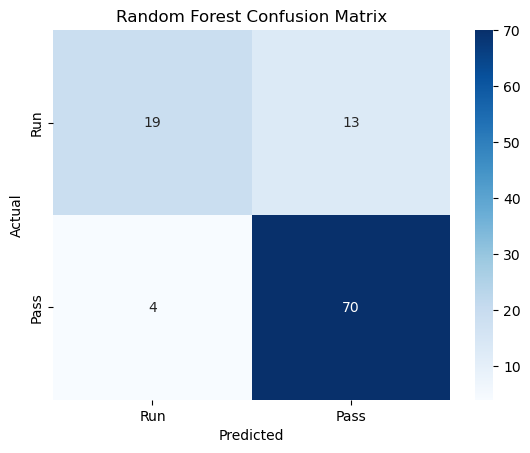

In [8]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    average_precision_score, confusion_matrix, classification_report
)
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# Static XGBoost Model
xgb_params = {'max_depth': 3, 'learning_rate': 0.0538541025885735, 
              'subsample': 0.6853761664792607, 'colsample_bytree': 0.9413928236975928, 
              'n_estimators': 492, 'reg_alpha': 5.175471769305277, 'reg_lambda': 3.5224681139068257}

xgb_model = xgb.XGBClassifier(**xgb_params, random_state=28)
xgb_model.fit(X_train_full, y_train_full)

# Static Random Forest Model
rf_params = {'n_estimators': 281, 'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 0.42508346812834447}

rf_model = RandomForestClassifier(**rf_params, random_state=28, n_jobs=-1, class_weight='balanced')
rf_model.fit(X_train_full, y_train_full)

# Evaluate XGBoost
y_test_pred_xgb = xgb_model.predict(X_test)
y_test_pred_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

xgb_metrics = {
    'accuracy': accuracy_score(y_test, y_test_pred_xgb),
    'precision': precision_score(y_test, y_test_pred_xgb),
    'recall': recall_score(y_test, y_test_pred_xgb),
    'f1_score': f1_score(y_test, y_test_pred_xgb),
    'roc_auc': roc_auc_score(y_test, y_test_pred_proba_xgb),
    'pr_auc': average_precision_score(y_test, y_test_pred_proba_xgb)
}

print("\nXGBoost Metrics:")
for metric, value in xgb_metrics.items():
    print(f"  {metric}: {value:.4f}")

print("\nXGBoost Classification Report:")
print(classification_report(y_test, y_test_pred_xgb))

# Confusion Matrix for XGBoost
conf_matrix_xgb = confusion_matrix(y_test, y_test_pred_xgb)
sns.heatmap(conf_matrix_xgb, annot=True, fmt='d', cmap='Blues', xticklabels=['Run', 'Pass'], yticklabels=['Run', 'Pass'])
plt.title("XGBoost Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Evaluate Random Forest
y_test_pred_rf = rf_model.predict(X_test)
y_test_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]

rf_metrics = {
    'accuracy': accuracy_score(y_test, y_test_pred_rf),
    'precision': precision_score(y_test, y_test_pred_rf),
    'recall': recall_score(y_test, y_test_pred_rf),
    'f1_score': f1_score(y_test, y_test_pred_rf),
    'roc_auc': roc_auc_score(y_test, y_test_pred_proba_rf),
    'pr_auc': average_precision_score(y_test, y_test_pred_proba_rf)
}

print("\nRandom Forest Metrics:")
for metric, value in rf_metrics.items():
    print(f"  {metric}: {value:.4f}")

print("\nRandom Forest Classification Report:")
print(classification_report(y_test, y_test_pred_rf))

# Confusion Matrix for Random Forest
conf_matrix_rf = confusion_matrix(y_test, y_test_pred_rf)
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', xticklabels=['Run', 'Pass'], yticklabels=['Run', 'Pass'])
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
